# Analyze Phase I of Condition 1, 2 & 3

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
import scipy.stats as stats
from scipy.stats import pearsonr
import random
import datetime
import scipy
import math

from params import *
from utils import *
from key import *

In [63]:
sshtunnel.SSH_TIMEOUT = 5.0
sshtunnel.TUNNEL_TIMEOUT = 5.0

with sshtunnel.SSHTunnelForwarder(
    ('ssh.pythonanywhere.com'),
    ssh_username='Grawi', ssh_password=ssh_password,
    remote_bind_address=('Grawi.mysql.pythonanywhere-services.com', 3306)
) as tunnel:
    print("Successfully connected to Pythonanywhere")
    connection = MySQLdb.connect(
        user='Grawi',
        passwd='david2202087',
        host='127.0.0.1', port=tunnel.local_bind_port,
        db='Grawi$Interactive_quiz_database',
    )
    # Do stuff
    print("Successfully connected to database")
    
    try:
        cursor = connection.cursor()
        df_1 = pd.read_sql("SELECT * FROM condition_1;", connection)
        df_1["experiment_type"] = "condition_1"
        df_2 = pd.read_sql("SELECT * FROM condition_2;", connection)
        df_2["experiment_type"] = "condition_2"
        df_3 = pd.read_sql("SELECT * FROM condition_3;", connection)
        df_3["experiment_type"] = "condition_3"
        print(f"Data read finished, length: condition 1 length {len(df_1)}, condition 2 length {len(df_2)}, condition 3 length {len(df_3)}")
    
    except Exception as e:
        print("Error:", e)
    
    finally:
        # Close the cursor and connection
        cursor.close()
        connection.close()

df_original = pd.concat([df_1, df_2, df_3])
df_original.tail(5)

2024-03-17 13:50:26,959| ERROR   | Password is required for key /Users/guodawei/.ssh/id_rsa


Successfully connected to Pythonanywhere
Successfully connected to database
Data read finished, length: condition 1 length 297, condition 2 length 600, condition 3 length 297


,participantId,assignmentId,projectId,attention_passed,total_time,identity_choices,ideologies,bot_detected,submit_time,non_ideology_answers,additional_answers,reason,experiment_type,ideology_answers,labels
292,FA68BF716AA445A384E204CF28D6CC6D,3ed58875-f0ef-4017-9cda-1c1aabcb0f4a,2da4e70d-29e6-4eaa-bff5-d9d7de00da7a,1,763.812,"[[6, 5], [4, 0], [8, 3]]",None,50,2023-10-12 08:29:52,"[{""answers"": [-100, 1.1333333333333329, -100],...","[[1.1, 1.5, -0.9]]",,condition_3,"[{""answers"": [1, 1, 0], ""time_to_answer"": [6.3...","[[2], [2], [0]]"
293,FC0A2CD7495F49A68934E3AF7939572F,5db466be-b506-4ca2-8c3b-ccbd376cf09f,2da4e70d-29e6-4eaa-bff5-d9d7de00da7a,1,788.396,"[[1, 3], [15, 2], [19, 5]]",None,35,2023-10-12 06:15:37,"[{""answers"": [-100, 3, -100], ""time_to_answer""...","[[-1.9, -1.5, 2]]",The consistent reaction speed seemed like a bo...,condition_3,"[{""answers"": [1, 0, 0], ""time_to_answer"": [5.7...","[[2, 9, 5], [0, 8, 6], [0, 4, 8]]"
294,FD264C6FCF6E42D784A7735447BC9618,53ec3702-4a45-424f-a539-3440dc2d28b3,2da4e70d-29e6-4eaa-bff5-d9d7de00da7a,1,553.751,"[[14, 5], [16, 2], [6, 3]]",None,52,2023-10-12 06:15:07,"[{""answers"": [-100, 0.1, -100], ""time_to_answe...","[[2, -2, -2]]",,condition_3,"[{""answers"": [1, 1, 0], ""time_to_answer"": [7.6...","[[2, 7], [0, 5, 8], [0, 4, 6]]"
295,FDE676393D42487380BB9E9FF2561795,b5abb789-50db-4597-8ce6-60505d0ed814,2da4e70d-29e6-4eaa-bff5-d9d7de00da7a,1,1618.780,"[[9, 2], [5, 3], [15, 1]]",None,13,2023-10-12 06:13:51,"[{""answers"": [-100, 0.9333333333333336, -100],...","[[0.9, 2, 1]]",NA,condition_3,"[{""answers"": [0, 1, 0], ""time_to_answer"": [7.6...","[[4, 8, 2], [5, 2, 7], [2, 8, 6]]"
296,FE415398E9F841EB88B0D293CC10F777,23205573-1f84-4655-a50b-c5d3538e983a,2da4e70d-29e6-4eaa-bff5-d9d7de00da7a,1,430.702,"[[16, 4], [2, 1], [14, 0]]",None,52,2023-09-17 15:26:23,"[{""answers"": [-100, 1.7, -100], ""time_to_answe...","[[1.7, -2, -1.9]]",I didn't choose bot because I thought it was s...,condition_3,"[{""answers"": [1, 0, 0], ""time_to_answer"": [8.4...","[[2, 7, 9], [4, 6, 8], [4, 6, 8]]"


## 1. Proprocess

In [64]:
df = df_original.copy()
failed_attention_ids = df.loc[df["attention_passed"] == 0]["participantId"].tolist()
print(f"{len(failed_attention_ids) } participants failed the attention check: {failed_attention_ids}")
df = df.loc[df["attention_passed"] == 1]
columns_to_drop = ['assignmentId', 'projectId', 'attention_passed', 'total_time', 'identity_choices', 'ideologies', 'submit_time', "reason", "non_ideology_answers", "labels", "bot_detected"]
df.drop(columns=columns_to_drop, inplace=True, axis=1)

cols_to_parse = ["additional_answers"]
for col in cols_to_parse:
    df[col] = df[col].apply(lambda x: literal_eval(x) if pd.notnull(x) else x)
df.set_index("participantId", inplace=True)

# Column "ideology_answers" of some participants are corrupted, so we need to remove them
data_error_ids = []
for id, row in df.iterrows():
    if pd.notnull(row["ideology_answers"]):
        try:
            literal_eval(row["ideology_answers"])
        except:
            data_error_ids.append(id)
            df.drop(index=id, inplace=True, axis=0)
print(f"There are {len(data_error_ids)} data errors, ids: {data_error_ids}")
df["ideology_answers"] = df["ideology_answers"].apply(lambda x: literal_eval(x) if pd.notnull(x) else x)
df.tail(3)

32 participants failed the attention check: ['363DEB2413FB48FD9D4CDCFD0EFE8171', '37A77F60BA16417D9170FF3AB76FFED3', '5911B1A9AE6D4E3388B295D078B7F49A', '60B62D2058D24418965396147B2746C3', '85364190604C4998AE9892A92449CB28', '9B32FED49EA64ABF85DB84B245455B26', 'DAF3701025BB4377BC901C1D6989C6A6', 'F5F966E8A63F467E9ABC254186478292', '0660BC35F9D84A76AD94D044AB3E2F03', '07CB55A4B0EF4F969562F92636F194C4', '0AAAF5A90BE94134BA67E17D5C757684', '2E5CC51E01154406807CDCAB36006E62', '5CEE6A3A286F4719B90C4676FCD8E2FC', '67D7C1011797450CA613E3C92A47118F', '67E7D55F665A49D38C82E49C72B7077B', '69E4C35A0296446D87A626AF9CDA1A71', '755DFFC11EE74976929C37FF43133426', '79AF6A78556249CBAE9F5E92BD9A10A1', '7C7C5A02D261468B933EF149B2A04D9D', '8CBEF3832F99441C89B7952F00421DC6', '9FF5D3BF714E4790AA2D2CEE3F99C74E', 'ADD051D15E114D4CB67AD31B0FA8F673', 'B9E4A5C4C1D6458F9DEF6E9C7D4CB92F', '0B73691B78694428A89DC54000E21248', '208C4E3596D44FCF81020892DBFF3DDA', '442A4DBB859746FE8F9EDBEB6AD1A519', '54595FC00C524A20A8

,additional_answers,experiment_type,ideology_answers
participantId,,,
FC0A2CD7495F49A68934E3AF7939572F,"[[-1.9, -1.5, 2]]",condition_3,"[{'answers': [1, 0, 0], 'time_to_answer': [5.7..."
FD264C6FCF6E42D784A7735447BC9618,"[[2, -2, -2]]",condition_3,"[{'answers': [1, 1, 0], 'time_to_answer': [7.6..."
FDE676393D42487380BB9E9FF2561795,"[[0.9, 2, 1]]",condition_3,"[{'answers': [0, 1, 0], 'time_to_answer': [7.6..."


In [65]:
df = df.loc[df["experiment_type"] == "condition_2"]
df["ideology"] = df["additional_answers"].apply(lambda x: x[0][1])
df_question = df.explode("ideology_answers")
df_question["answer"] = df_question["ideology_answers"].apply(lambda x: x["answers"][1])
df_question["index"] = df_question["ideology_answers"].apply(lambda x: x["idx_of_question"])
df_question.drop(["additional_answers", "experiment_type", "ideology_answers"], axis=1, inplace=True)
df_question.tail()

,ideology,answer,index
participantId,,,
FF9C24AEDDAC4F50B5C072C0AAE0C15A,-2.0,0,8
FF9C24AEDDAC4F50B5C072C0AAE0C15A,-2.0,0,1
FF9C24AEDDAC4F50B5C072C0AAE0C15A,-2.0,0,7
FF9C24AEDDAC4F50B5C072C0AAE0C15A,-2.0,1,0
FF9C24AEDDAC4F50B5C072C0AAE0C15A,-2.0,1,4


In [66]:
from params import phase_1_statements

def is_liberal_answer(row):
    index = int(row['index'])
    answer = row['answer']
    info = phase_1_statements[index]
    assert info['type'] != 'preference', "Cannot get the liberal answer for question of preference"
    return info['left_attitude'] and answer == 0 or not info['left_attitude'] and answer == 1

def is_extreme_liberal_answer(row):
    info = phase_1_statements[int(row['index'])]
    return info['extreme'] and row['answer'] == 0 and info['left_attitude']

def is_extreme_conservative_answer(row):
    info = phase_1_statements[int(row['index'])]
    return int(row['index']) != 9 and info['extreme'] and row['answer'] == 0 and not info['left_attitude']

def get_liberal_weight(row):
    index = int(row['index'])
    answer = row['answer']
    info = phase_1_statements[index]
    assert info['type'] != 'preference', "Cannot get the liberal answer for question of preference"
    if index == 9:
        return 0
    if not info['extreme']:
        if info['left_attitude'] and answer == 0 or not info['left_attitude'] and answer == 1:
            return 1
        else:
            return -1
    else:
        if info['left_attitude']:
            if answer == 0:
                return 2
            else:
                return -0.5
        else:
            if answer == 0:
                return -2
            else:
                return 0.5

df_question['question_liberal_weight'] = df_question.apply(get_liberal_weight, axis=1)
# df_question['is_liberal'] = df_question.apply(is_liberal_answer, axis=1)
# df_question['is_extreme_liberal'] = df_question.apply(is_extreme_liberal_answer, axis=1)
# df_question['is_extreme_conservative'] = df_question.apply(is_extreme_conservative_answer, axis=1)
df_question.head()

,ideology,answer,index,question_liberal_weight
participantId,,,,
009AFBEE6704466A96A1BDFDF031CACC,0.0,0,6,-2.0
009AFBEE6704466A96A1BDFDF031CACC,0.0,1,2,1.0
009AFBEE6704466A96A1BDFDF031CACC,0.0,1,3,-1.0
009AFBEE6704466A96A1BDFDF031CACC,0.0,1,4,1.0
009AFBEE6704466A96A1BDFDF031CACC,0.0,0,8,2.0


## 2. Determine Bots' Phase I Answers

Text(0, 0.5, 'Liberal Weight')

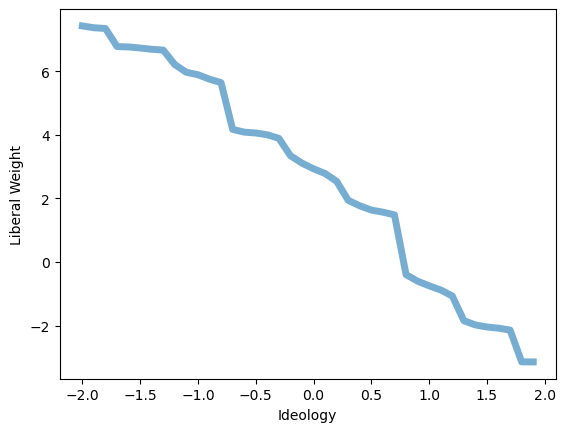

In [79]:

df["liberal_weight"] = df_question.groupby("participantId")["question_liberal_weight"].sum()

avg, low, high = sliding_average(df["ideology"], df["liberal_weight"])
plt.plot(avg.index, avg.values, lw=5, alpha=0.6)
plt.xlabel("Ideology")
plt.ylabel("Liberal Weight")

In [216]:
df_question["participant_liberal_weight"] = df_question.groupby("participantId")["question_liberal_weight"].sum()
df_question["participant_liberal_weight_rank"] = df_question["participant_liberal_weight"].rank(method="first") / len(df_question)
# df_temp = df_question.loc[(df_question["participant_liberal_weight_rank"] < 0.0205)
df_temp = df_question.loc[(df_question["participant_liberal_weight_rank"] > 0.1) & (df_question["participant_liberal_weight_rank"] <= 0.2)]
df_temp = df_question.loc[(df_question["participant_liberal_weight_rank"] > 0.7) & (df_question["participant_liberal_weight_rank"] <= 0.8)]
df_temp = df_question.loc[(df_question["participant_liberal_weight_rank"] > 0.95)]
print(df_temp.groupby("index")["answer"].mean().tolist())

[0.03333333333333333, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0]
